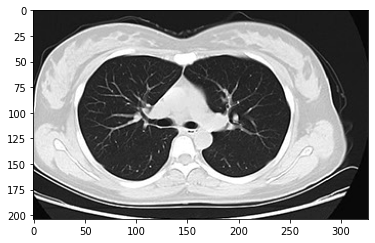

100%|██████████| 397/397 [00:02<00:00, 183.37it/s]


1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
[[[[ 91]
   [ 46]
   [ 47]
   ...
   [ 41]
   [ 41]
   [ 46]]

  [[ 88]
   [ 47]
   [ 49]
   ...
   [ 42]
   [ 41]
   [ 46]]

  [[ 83]
   [ 48]
   [ 50]
   ...
   [ 42]
   [ 42]
   [ 46]]

  ...

  [[166]
   [212]
   [135]
   ...
   [ 44]
   [ 41]
   [ 47]]

  [[104]
   [189]
   [188]
   ...
   [ 44]
   [ 41]
   [ 47]]

  [[ 56]
   [147]
   [229]
   ...
   [ 44]
   [ 41]
   [ 46]]]]
Train on 284 samples, validate on 122 samples


AttributeError: ignored

In [ ]:
##Early stopping COVID_CT

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs\{}".format(time()), histogram_freq=0)

DATADIR = "/content/drive/My Drive/covid-19/train"

CATEGORIES = ["CT_COVID", "CT_NonCOVID"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

training_data = []
IMG_SIZE = 200
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

random.shuffle(training_data)
for sample in training_data[20:40]:
    print(sample[1])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)



pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)


pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

NAME = "COVID-19_Earlystopping"
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))
callback = TensorBoard(log_dir="logs/{}".format(NAME))
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

model.fit(X, y,
          batch_size=32,
          epochs=1,
          validation_split=0.3,
          callbacks=[callback])



In [ ]:
print("/content/logs")

/content/logs


In [ ]:
model.save('model.h5')
model.summary()

In [ ]:
import time
from tensorflow import keras
new_model = keras.models.load_model('model.h5')
new_model.summary()



In [ ]:
import time
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
# define optimizer
X = X/255
sgd = tf.keras.optimizers.SGD(lr=0.1)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

model.fit(X, y,batch_size=32,epochs=1,validation_split=0.3,callbacks=[callback])

#model.fit(X, y, batch_size=32,epochs=3,validation_split=0.3,callbacks=[callback])

#model.evaluate(test_dataset)

In [ ]:
import os
import numpy as np
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import resnet


NUM_GPUS = 1
BS_PER_GPU = 128

HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 10
NUM_TRAIN_SAMPLES = 50000

BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 10), (0.01, 20)]

NUM_EPOCHS = 10


def normalize(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y


def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 8, WIDTH + 8)
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y 


def schedule(epoch):
  initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
  learning_rate = initial_learning_rate
  for mult, start_epoch in LR_SCHEDULE:
    if epoch >= start_epoch:
      learning_rate = initial_learning_rate * mult
    else:
      break
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate


(x,y), (x_test, y_test) = keras.datasets.cifar10.load_data()

train_dataset = tf.data.Dataset.from_tensor_slices((x,y))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

tf.random.set_seed(22)
train_dataset = train_dataset.shuffle(NUM_TRAIN_SAMPLES).map(augmentation).map(normalize).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)
test_dataset = test_dataset.map(normalize).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)


input_shape = (HEIGHT, WIDTH, NUM_CHANNELS)
img_input = tf.keras.layers.Input(shape=input_shape)

model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)

# define optimizer
sgd = tf.keras.optimizers.SGD(lr=0.1)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=1, verbose=1, mode='auto')

model.fit(train_dataset,
          epochs=NUM_EPOCHS, callbacks=[earlystop_callback],
          validation_data=test_dataset,
          validation_freq=1)

